In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

In [4]:
from scipy.signal.windows import dpss

In [5]:
from tqdm import tqdm

In [7]:
# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[38]
print(Lambda)
chis_resample_len = 13

oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)



0.07543120063354623


In [8]:
dchi = np.mean(np.diff(chis_resample))

# trying to figure out dpss

In [9]:
_LAMBDA = Lambda

In [10]:
_chimax - _chimin

2208.86086339498

In [12]:
M = len(eHIeHI)
NW = (_chimax - _chimin) * _LAMBDA / (2 * np.pi) 
   # window lenght * band width

v = dpss(M = M,
         NW = NW,
         Kmax = 30, sym = False)

v_k = np.fft.rfft(v)
k = 2*np.pi*np.fft.rfftfreq(len(v[0]), d = dchi)

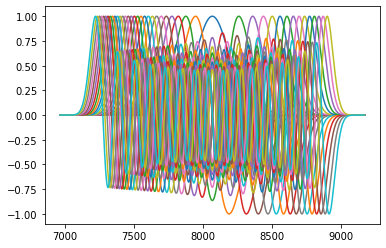

In [13]:
plt.plot(chis_resample[window], v.T/np.max(v, axis=1))

[]

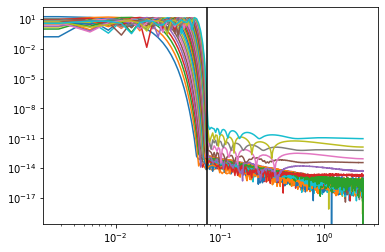

In [14]:
plt.plot(k, np.abs(v_k.T))

plt.axvline(_LAMBDA, c='k')
plt.xscale('log')
plt.loglog()

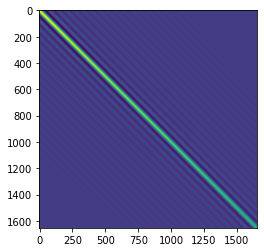

In [15]:
plt.imshow(eIeLO + eLOeI)

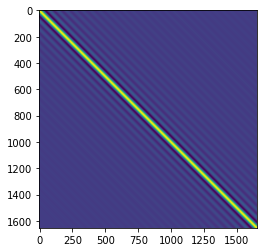

In [16]:
plt.imshow((eIeLO + eLOeI) * chis_resample[window] ** 2)

In [17]:
eigenvalues, eigenvectors = np.linalg.eigh(eHIeHI * chis_resample[window] ** 2)
print(eigenvalues.shape, eigenvectors.shape)

(1652,) (1652, 1652)


In [18]:
idx_sort = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx_sort][::-1]
eigenvectors = eigenvectors[idx_sort][::-1]

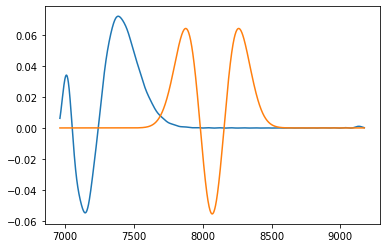

In [19]:
plt.plot(chis_resample[window], eigenvectors.T[2])
plt.plot(chis_resample[window],v[2])

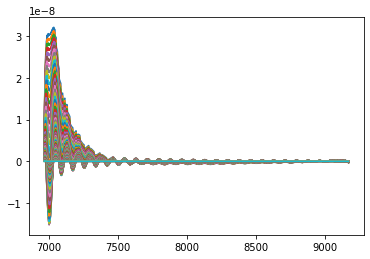

In [20]:
plt.plot(chis_resample[window], IHi_kappa_windowed.T);

In [21]:
IHi_kappa_windowed_k = np.fft.rfft(IHi_kappa_windowed)

[]

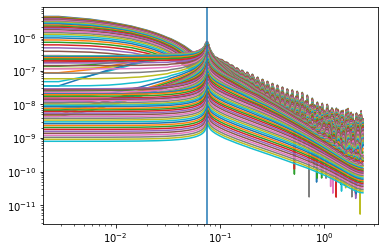

In [22]:
plt.plot(k, np.abs(IHi_kappa_windowed_k.T))
plt.axvline(Lambda)
plt.loglog()

# computing snr per mode

In [23]:
L = np.linalg.cholesky(eHIeHI)
y = np.linalg.solve(L, IHi_kappa_windowed.T)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', IHi_kappa_windowed, x)


LinAlgError: Matrix is not positive definite

In [24]:
L = np.linalg.cholesky(eHIeHI * chis_resample[window] ** 2)
y = np.linalg.solve(L, IHi_kappa_windowed.T )
x = np.linalg.solve(L.T, y) 
res8 = np.einsum('ij, ji->i', chis_resample[window] ** 2 * IHi_kappa_windowed, x )


In [26]:
from scipy.signal.windows import dpss


def tmp(cov = eHIeHI, D=np.eye(len(eIeI)), factor = 2):
    
    M = len(cov)
    NW = (_chimax - _chimin) * Lambda / (2 * np.pi)    
    Kmax = max(1, int(min(factor * NW * M, M)))
    
    print(M, Kmax)
    v = dpss(M = M,
             NW = NW,
             Kmax = Kmax)
    print(v.shape, cov.shape, v.T.shape)
    cov_dpss = v @ cov @ D @ v.T
    cov_dpss_inv = np.diag(1.0 / np.diag(cov_dpss))
    cov_inv  = v.T @ cov_dpss_inv @ v
    return np.einsum('ij, jk, ki->i', IHi_kappa_windowed, cov_inv, D @ IHi_kappa_windowed.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


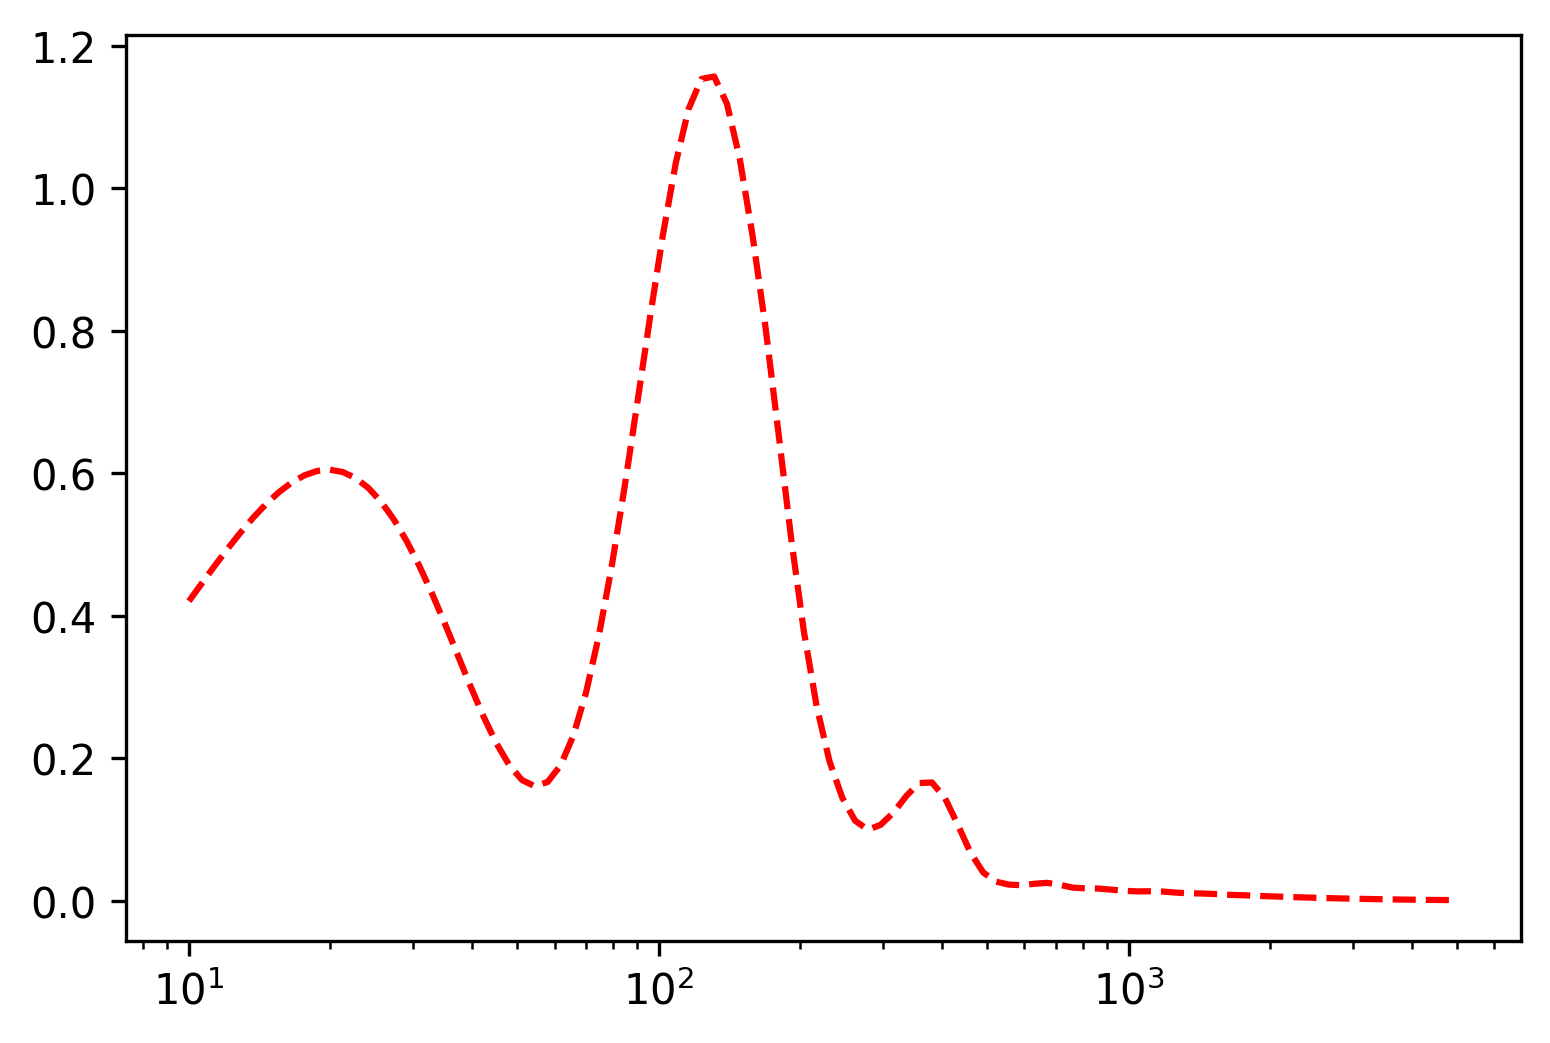

In [27]:
plt.figure(dpi = 300)
# plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res8, 'r--')

plt.legend(frameon=False)
plt.xscale('log')

In [29]:
D = np.diag(chis_resample[window] ** 2)

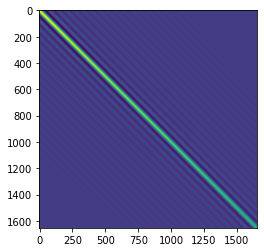

In [46]:
plt.imshow((eIeLO + eLOeI) )

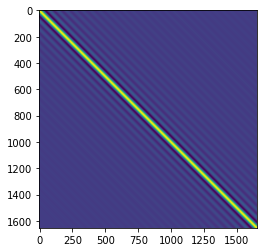

In [45]:
plt.imshow((eIeLO + eLOeI) @ D)

In [34]:
cov = eHIeHI @ D


factor = 2
M = len(cov)
NW = (_chimax - _chimin) * Lambda / (2 * np.pi)    
Kmax = max(1, int(min(factor * NW * M, M)))
v = dpss(M = M,
         NW = NW,
         Kmax = Kmax // 2)
cov_dpss = v @ cov @ v.T
cov_dpss_inv = np.diag(1.0 / np.diag(cov_dpss))
cov_inv  = v.T @ cov_dpss_inv @ v



res2 = np.einsum('ij, jk, ki->i', IHi_kappa_windowed, cov_inv, D @ IHi_kappa_windowed.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


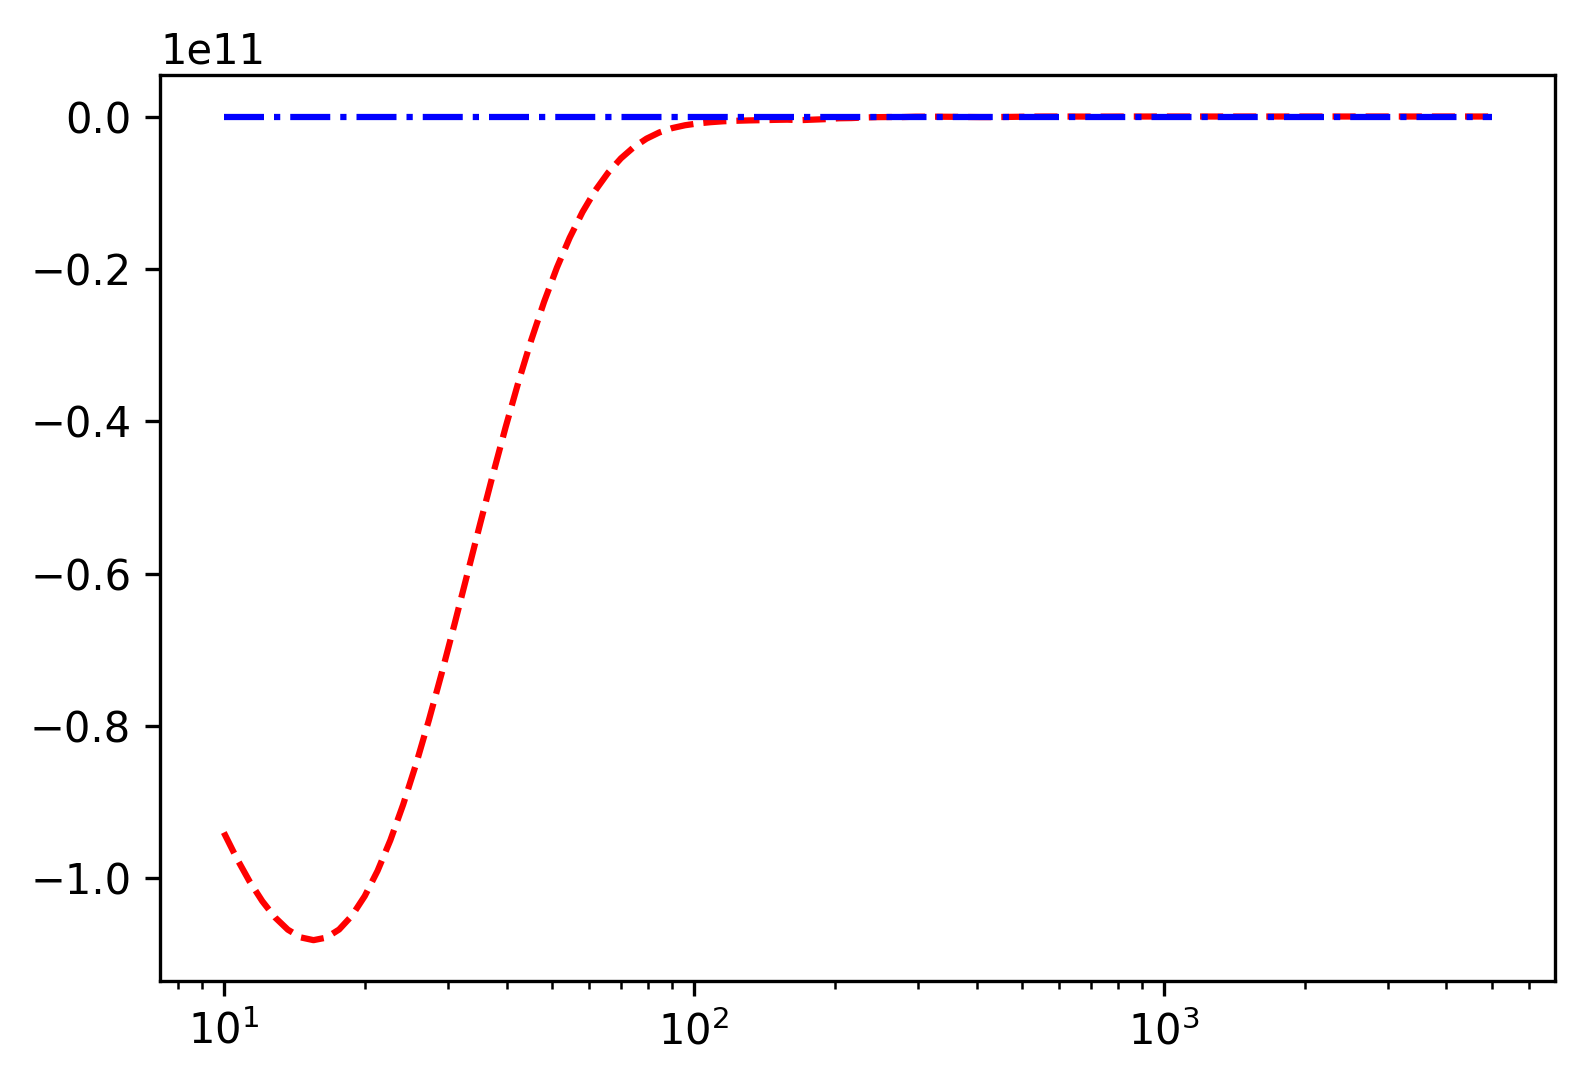

In [39]:
plt.figure(dpi = 300)
# plt.plot(ells, ells**2 * res1, 'k')

factor = 2
plt.plot(ells, ells**2 * res2, 'r--')

plt.plot(ells, ells**2 * res8, 'b-.')

plt.legend(frameon=False)
# plt.ylim(0, 2)
plt.xscale('log')